# Sentiment Analysis: GPT 3.5 Turbo vs FinBERT  

This document has the aim of making a comparison between the two models in the financial news classification task.   

Classifications made with FinBERT can be found at:  
https://github.com/flaviobrienza/Dissertation  

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (15, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

import warnings
warnings.simplefilter(action='ignore')

import langchain 
from langchain.chains import create_tagging_chain 
from secret_api_key import openaikey
from langchain.chat_models import ChatOpenAI 

## Importing Data  

This is the news' dataset used in my dissertation to make classification. Only news headers are included.   

FinBERT scores are provided for each news and they are probabilities obtained through the softmax function.

In [2]:
news = pd.read_csv('C:/Users/FLAVIO/OneDrive/Desktop/Dissertation/Dissertation_ML_NLP/company_news.csv')
news

,Company,News,roberta_scores,rob_neg,rob_neu,rob_pos,finbert_scores,fin_neg,fin_neu,fin_pos
0,AAPL,What leaders are saying about the economy in t...,"{'negative_score': 0.019849356, 'neutral_score...",0.019849,0.944306,0.035845,"{'negative_score': 0.0004181307, 'neutral_scor...",0.000418,0.999563,0.000019
1,AAPL,Are There Rough Waters Ahead On Tech Earnings ...,"{'negative_score': 0.14316593, 'neutral_score'...",0.143166,0.834439,0.022395,"{'negative_score': 0.00021061316, 'neutral_sco...",0.000211,0.999761,0.000028
2,AAPL,Apple Plans iPhone Journaling App in Expansion...,"{'negative_score': 0.0076362663, 'neutral_scor...",0.007636,0.728212,0.264151,"{'negative_score': 8.6331875e-06, 'neutral_sco...",0.000009,0.989234,0.010757
3,AAPL,Apple Pays Long Road to Paying Off Is Getting ...,"{'negative_score': 0.37146127, 'neutral_score'...",0.371461,0.556915,0.071623,"{'negative_score': 0.010994043, 'neutral_score...",0.010994,0.884704,0.104302
4,AAPL,3 Red Flags for Alphabet's Future,"{'negative_score': 0.0047791433, 'neutral_scor...",0.004779,0.434086,0.561135,"{'negative_score': 0.0019774495, 'neutral_scor...",0.001977,0.066884,0.931138
...,...,...,...,...,...,...,...,...,...,...
3944,BABA,Dow Futures: Market Rally Rebounds Into Jobs R...,"{'negative_score': 0.007077664, 'neutral_score...",0.007078,0.294857,0.698066,"{'negative_score': 2.6010327e-06, 'neutral_sco...",0.000003,0.000002,0.999996
3945,BABA,China's Alibaba invites businesses to trial AI...,"{'negative_score': 0.017476948, 'neutral_score...",0.017477,0.868089,0.114434,"{'negative_score': 1.133459e-05, 'neutral_scor...",0.000011,0.999446,0.000543
3946,BABA,Alibaba Touts ChatGPT Challenger Ahead of Main...,"{'negative_score': 0.007346885, 'neutral_score...",0.007347,0.937665,0.054988,"{'negative_score': 1.2057671e-05, 'neutral_sco...",0.000012,0.999149,0.000839
3947,BABA,Why Shares of Alibaba Are Rising Today,"{'negative_score': 0.010822894, 'neutral_score...",0.010823,0.512837,0.476341,"{'negative_score': 0.00052446965, 'neutral_sco...",0.000524,0.050263,0.949212


Filtering only necessary columns

In [4]:
news = news[['Company', 'News', 'fin_neg', 'fin_neu', 'fin_pos']] 
news

,Company,News,fin_neg,fin_neu,fin_pos
0,AAPL,What leaders are saying about the economy in t...,0.000418,0.999563,0.000019
1,AAPL,Are There Rough Waters Ahead On Tech Earnings ...,0.000211,0.999761,0.000028
2,AAPL,Apple Plans iPhone Journaling App in Expansion...,0.000009,0.989234,0.010757
3,AAPL,Apple Pays Long Road to Paying Off Is Getting ...,0.010994,0.884704,0.104302
4,AAPL,3 Red Flags for Alphabet's Future,0.001977,0.066884,0.931138
...,...,...,...,...,...
3944,BABA,Dow Futures: Market Rally Rebounds Into Jobs R...,0.000003,0.000002,0.999996
3945,BABA,China's Alibaba invites businesses to trial AI...,0.000011,0.999446,0.000543
3946,BABA,Alibaba Touts ChatGPT Challenger Ahead of Main...,0.000012,0.999149,0.000839
3947,BABA,Why Shares of Alibaba Are Rising Today,0.000524,0.050263,0.949212


Creating a column with the final evaluation

In [12]:
news['final_evaluation'] = news[['fin_neg', 'fin_neu', 'fin_pos']].idxmax(axis=1).replace(['fin_neg', 'fin_neu', 'fin_pos'], ['negative', 'neutral', 'positive']) 
news

,Company,News,fin_neg,fin_neu,fin_pos,final_evaluation
0,AAPL,What leaders are saying about the economy in t...,0.000418,0.999563,0.000019,neutral
1,AAPL,Are There Rough Waters Ahead On Tech Earnings ...,0.000211,0.999761,0.000028,neutral
2,AAPL,Apple Plans iPhone Journaling App in Expansion...,0.000009,0.989234,0.010757,neutral
3,AAPL,Apple Pays Long Road to Paying Off Is Getting ...,0.010994,0.884704,0.104302,neutral
4,AAPL,3 Red Flags for Alphabet's Future,0.001977,0.066884,0.931138,positive
...,...,...,...,...,...,...
3944,BABA,Dow Futures: Market Rally Rebounds Into Jobs R...,0.000003,0.000002,0.999996,positive
3945,BABA,China's Alibaba invites businesses to trial AI...,0.000011,0.999446,0.000543,neutral
3946,BABA,Alibaba Touts ChatGPT Challenger Ahead of Main...,0.000012,0.999149,0.000839,neutral
3947,BABA,Why Shares of Alibaba Are Rising Today,0.000524,0.050263,0.949212,positive


Taking only necessary columns

In [14]:
news = news[['Company', 'News', 'final_evaluation']]
news

,Company,News,final_evaluation
0,AAPL,What leaders are saying about the economy in t...,neutral
1,AAPL,Are There Rough Waters Ahead On Tech Earnings ...,neutral
2,AAPL,Apple Plans iPhone Journaling App in Expansion...,neutral
3,AAPL,Apple Pays Long Road to Paying Off Is Getting ...,neutral
4,AAPL,3 Red Flags for Alphabet's Future,positive
...,...,...,...
3944,BABA,Dow Futures: Market Rally Rebounds Into Jobs R...,positive
3945,BABA,China's Alibaba invites businesses to trial AI...,neutral
3946,BABA,Alibaba Touts ChatGPT Challenger Ahead of Main...,neutral
3947,BABA,Why Shares of Alibaba Are Rising Today,positive


Taking only a sample of news, 2 per company. There will be 80 news in the final dataset. 

In [17]:
final_news = pd.DataFrame()

for x in news.Company.unique():
    c_df = news[news.Company == x].sample(2)
    final_news = pd.concat([final_news, c_df]) 

In [19]:
final_news.reset_index().drop(columns='index')

,Company,News,final_evaluation
0,AAPL,Apple Opens Its First Retail Store in India,neutral
1,AAPL,Google 'remains the leader in AI' despite lack...,neutral
2,MSFT,Microsoft (MSFT) Azure Expands Strategic Partn...,positive
3,MSFT,Google Stock Falls On Report Samsung Could Swi...,neutral
4,IBM,"These Stocks Are Moving the Most Today: Tesla,...",neutral
...,...,...,...
75,TSLA,Move over Thor: Fords Lightning EV heading to ...,neutral
76,EBAY,"Etsy is very proactive in monitoring, removing...",positive
77,EBAY,A Bull Market Is Coming: 3 Reasons to Buy eBay...,positive
78,BABA,China's Alibaba invites businesses to trial AI...,neutral


Storing

In [20]:
final_news.to_csv('final_news.csv', index=None)

## GPT 3.5 Tagging Process  

In [2]:
final_news = pd.read_csv('./final_news.csv') 
final_news

,Company,News,final_evaluation
0,AAPL,Apple Opens Its First Retail Store in India,neutral
1,AAPL,Google 'remains the leader in AI' despite lack...,neutral
2,MSFT,Microsoft (MSFT) Azure Expands Strategic Partn...,positive
3,MSFT,Google Stock Falls On Report Samsung Could Swi...,neutral
4,IBM,"These Stocks Are Moving the Most Today: Tesla,...",neutral
...,...,...,...
75,TSLA,Move over Thor: Fords Lightning EV heading to ...,neutral
76,EBAY,"Etsy is very proactive in monitoring, removing...",positive
77,EBAY,A Bull Market Is Coming: 3 Reasons to Buy eBay...,positive
78,BABA,China's Alibaba invites businesses to trial AI...,neutral


### Defining the LLM 

In [3]:
llm = ChatOpenAI(model='gpt-3.5-turbo-1106', temperature=0, openai_api_key=openaikey) 

### Defining the Schema  

This is necessary to make the model understand how to classify news. 

In [4]:
schema = {
    'properties': {
        'sentiment': {
            'type':'string', # the tagging variable type 
            'enum':['negative', 'neutral', 'positive'], # the classes to predict. It is like ENUM in SQL 
            'description':'''You are asked to classify a financial news by only using its header.'''
        },
        'reasoning':{
            'type':'string', 
            'description': '''Explain, in a concise way, why you gave that particular tag to the news'''
        }
    },
    'required':['sentiment', 'reasoning'] # it describes which properties must be shown in the tagged document
}

### Creating the Chain

In [5]:
chain = create_tagging_chain(schema=schema, llm=llm) 

### Testing

The news

In [6]:
final_news.News[3]

'Google Stock Falls On Report Samsung Could Switch To Microsoft Search Engine'

The tagging + the reasoning

In [7]:
test_news = final_news.News[3]

chain.run(test_news)

{'sentiment': 'negative',
 'reasoning': "The stock falling indicates a negative impact on Google's business due to the potential switch to Microsoft search engine by Samsung."}

#### Implementing a Function  

It will be implemented a function that will be passed to each news' header.

In [13]:
def news_tagger(row): 
    try: 
        schema = {
        'properties': {
            'sentiment': {
                'type':'string', # the tagging variable type 
                'enum':['negative', 'neutral', 'positive'], # the classes to predict. It is like ENUM in SQL 
                'description':'''You are asked to classify a financial news by only using its header.'''
            },
            'reasoning':{
                'type':'string', 
                'description': '''Explain, in a concise way, why you gave that particular tag to the news'''
            }
        },
        'required':['sentiment', 'reasoning'] # it describes which properties must be shown in the tagged document
        }
        llm = ChatOpenAI(model='gpt-3.5-turbo-1106', temperature=0, openai_api_key=openaikey)
        chain = create_tagging_chain(schema=schema, llm=llm) 
        return chain.run(row['News']) 
    
    except: 
        return 'Failed request'

Applying the function

In [14]:
final_news['gpt_eval'] = final_news.apply(news_tagger, axis=1)

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


In [15]:
final_news

,Company,News,final_evaluation,gpt_eval
0,AAPL,Apple Opens Its First Retail Store in India,neutral,"{'sentiment': 'positive', 'reasoning': 'Apple ..."
1,AAPL,Google 'remains the leader in AI' despite lack...,neutral,"{'sentiment': 'positive', 'reasoning': 'Google..."
2,MSFT,Microsoft (MSFT) Azure Expands Strategic Partn...,positive,"{'sentiment': 'positive', 'reasoning': 'The ex..."
3,MSFT,Google Stock Falls On Report Samsung Could Swi...,neutral,"{'sentiment': 'negative', 'reasoning': 'The st..."
4,IBM,"These Stocks Are Moving the Most Today: Tesla,...",neutral,"{'sentiment': 'neutral', 'reasoning': 'The pas..."
...,...,...,...,...
75,TSLA,Move over Thor: Fords Lightning EV heading to ...,neutral,"{'sentiment': 'positive', 'reasoning': 'The ne..."
76,EBAY,"Etsy is very proactive in monitoring, removing...",positive,"{'sentiment': 'positive', 'reasoning': 'Etsy's..."
77,EBAY,A Bull Market Is Coming: 3 Reasons to Buy eBay...,positive,"{'sentiment': 'positive', 'reasoning': 'The pa..."
78,BABA,China's Alibaba invites businesses to trial AI...,neutral,"{'sentiment': 'neutral', 'reasoning': 'Alibaba..."


Storing

In [16]:
final_news.to_csv('final_news.csv', index=None)

Looking for failed requests

In [17]:
final_news[final_news.gpt_eval == 'Failed request']

,Company,News,final_evaluation,gpt_eval


Converting the dictionary in "gpt_eval" into a dataframe

In [21]:
eval_dict = {} 

for index, evals in zip(final_news.index, final_news.gpt_eval):
    eval_dict[index] = evals

Converting to a dataframe

In [26]:
pd.DataFrame(eval_dict)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
sentiment,positive,positive,positive,negative,neutral,neutral,positive,neutral,positive,neutral,...,neutral,positive,positive,positive,negative,positive,positive,positive,neutral,neutral
reasoning,Apple opening its first retail store in India ...,"Google is recognized as the leader in AI, whic...",The expansion of the strategic partnership bet...,The stock falling indicates a negative impact ...,The passage provides a list of stocks that are...,The news headline suggests that IBM could be w...,The passage indicates a successful migration t...,"The passage highlights multiple companies, ind...",Salesforce has avoided a proxy fight with Elli...,The news about Salesforce unveiling Generative...,...,The news is neutral because it simply reports ...,"The stock outpaced the market gains, indicatin...",Amazon's announcement of an Anti-Counterfeitin...,The passage suggests that there are 22 ways to...,The headline indicates that Tesla stock had a ...,The news about Ford's Lightning EV heading to ...,Etsy's proactive approach in monitoring and re...,The passage suggests that a bull market is com...,Alibaba's invitation to businesses to trial an...,The news about Alibaba unveiling Tongyi Qianwe...


In [29]:
gpt_eval_df = pd.DataFrame(eval_dict).T.rename(columns={'sentiment':'gpt_sentiment'})  
gpt_eval_df

,gpt_sentiment,reasoning
0,positive,Apple opening its first retail store in India ...
1,positive,"Google is recognized as the leader in AI, whic..."
2,positive,The expansion of the strategic partnership bet...
3,negative,The stock falling indicates a negative impact ...
4,neutral,The passage provides a list of stocks that are...
...,...,...
75,positive,The news about Ford's Lightning EV heading to ...
76,positive,Etsy's proactive approach in monitoring and re...
77,positive,The passage suggests that a bull market is com...
78,neutral,Alibaba's invitation to businesses to trial an...


Putting everything together

In [33]:
final_news = final_news.merge(gpt_eval_df, left_index=True, right_index=True).drop(columns='gpt_eval')
final_news

,Company,News,final_evaluation,gpt_sentiment,reasoning
0,AAPL,Apple Opens Its First Retail Store in India,neutral,positive,Apple opening its first retail store in India ...
1,AAPL,Google 'remains the leader in AI' despite lack...,neutral,positive,"Google is recognized as the leader in AI, whic..."
2,MSFT,Microsoft (MSFT) Azure Expands Strategic Partn...,positive,positive,The expansion of the strategic partnership bet...
3,MSFT,Google Stock Falls On Report Samsung Could Swi...,neutral,negative,The stock falling indicates a negative impact ...
4,IBM,"These Stocks Are Moving the Most Today: Tesla,...",neutral,neutral,The passage provides a list of stocks that are...
...,...,...,...,...,...
75,TSLA,Move over Thor: Fords Lightning EV heading to ...,neutral,positive,The news about Ford's Lightning EV heading to ...
76,EBAY,"Etsy is very proactive in monitoring, removing...",positive,positive,Etsy's proactive approach in monitoring and re...
77,EBAY,A Bull Market Is Coming: 3 Reasons to Buy eBay...,positive,positive,The passage suggests that a bull market is com...
78,BABA,China's Alibaba invites businesses to trial AI...,neutral,neutral,Alibaba's invitation to businesses to trial an...


Storing 

In [34]:
final_news.to_csv('final_news.csv', index=None)

## Analysis

In [3]:
final_news = pd.read_csv('./final_news.csv') 

Counting where predictions are the same

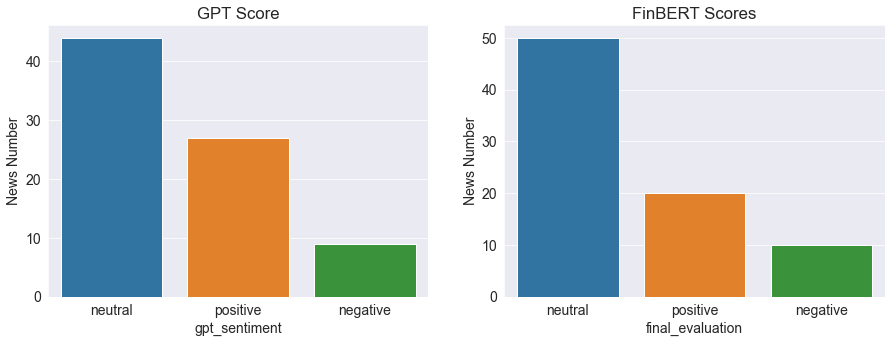

In [13]:
fig, ax = plt.subplots(1,2)

ax[0].set_title('GPT Score')
gpt_order = final_news.gpt_sentiment.value_counts().index
sns.countplot(
    data=final_news,
    x='gpt_sentiment',
    order=gpt_order,
    ax=ax[0]
)
ax[0].set_ylabel('News Number')

ax[1].set_title('FinBERT Scores')
finbert_order = final_news.final_evaluation.value_counts().index
sns.countplot(
    data=final_news,
    x='final_evaluation',
    order=finbert_order,
    ax=ax[1]
)
ax[1].set_ylabel('News Number');

Generally speaking, GPT has a lower amount of neutral news, while the positive ones increased. The negative are lower. 

Percentage of equal evaluations

In [4]:
print(f'The {(final_news[final_news.gpt_sentiment == final_news.final_evaluation].shape[0]/final_news.shape[0])*100}% of news have the same tag for both models')

The 73.75% of news have the same tag for both models


Some examples of different classification

In [14]:
final_news[final_news.gpt_sentiment != final_news.final_evaluation].sample(3)

,Company,News,final_evaluation,gpt_sentiment,reasoning
57,EOG,EOG Resources (EOG) Dips More Than Broader Mar...,neutral,negative,The stock of EOG Resources has dipped more tha...
36,UBS,Dont Overlook Undervalued Banking Giant UBS Stock,neutral,positive,The passage suggests that UBS stock is underva...
73,AMZN,Get Paid To Spend Money: 22 Ways You Can Get P...,neutral,positive,The passage suggests that there are 22 ways to...


In [35]:
links = [
    'https://finance.yahoo.com/news/don-t-overlook-undervalued-banking-142458261.html', 
    'https://finance.yahoo.com/news/eog-resources-eog-dips-more-220017125.html', 
    'https://finance.yahoo.com/news/paid-spend-money-22-ways-110048286.html'
]

links_index = 0

for idx, val in final_news.iterrows():
    if idx in (36,57,73):
        print(idx, f'News: {val.News}')
        print(idx, f'FinBERT Evaluation: {val.final_evaluation}')
        print(idx, f'GPT Eval: {val.gpt_sentiment}')
        print(idx, f'Reasoning: {val.reasoning}')
        print(idx, f'News link: {links[links_index]}\n')
        links_index += 1

36 News: Dont Overlook Undervalued Banking Giant UBS Stock
36 FinBERT Evaluation: neutral
36 GPT Eval: positive
36 Reasoning: The passage suggests that UBS stock is undervalued, which indicates a positive sentiment towards the stock.
36 News link: https://finance.yahoo.com/news/don-t-overlook-undervalued-banking-142458261.html

57 News: EOG Resources (EOG) Dips More Than Broader Markets: What You Should Know
57 FinBERT Evaluation: neutral
57 GPT Eval: negative
57 Reasoning: The stock of EOG Resources has dipped more than the broader markets, indicating a negative trend in its performance.
57 News link: https://finance.yahoo.com/news/eog-resources-eog-dips-more-220017125.html

73 News: Get Paid To Spend Money: 22 Ways You Can Get Paid to Go Shopping
73 FinBERT Evaluation: neutral
73 GPT Eval: positive
73 Reasoning: The passage suggests that there are 22 ways to get paid for shopping, which is a positive and appealing concept for many people.
73 News link: https://finance.yahoo.com/news/

This part provides the difference between the two algorithms. The links are useful to make a better evaluation by reading the entire news. 

# Conclusion   

This was a brief introduction to perform the news classification task using both FinBERT and GPT-3.5.   

About the latter, its **pros** are:  

- simpler to implement;  
- additional elements, like reasoining  

On the other hand the **cons** are:  

- speed depending on the API ingestion;  
- higher monetary cost